<a href="https://www.kaggle.com/code/giuseppei/birds?scriptVersionId=164195420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Intento de red neuronal usando el datased Birds 525 No.1


## 1: Importar librerias y configurer el API de Kaggle

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!rm kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download gpiosenka/100-bird-species

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from pathlib import Path
import zipfile
import os
from sklearn.metrics import classification_report
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2: Preparar el dataset (crear estructura de carpetas y descomprimir)


In [5]:
#DATA_PATH = Path("data/")
#IMAGE_PATH = DATA_PATH / "birds"

#if IMAGE_PATH.is_dir():
#  print(f"El directorio {IMAGE_PATH} ya existe.")
#else:
#  print(f"El directorio {IMAGE_PATH} no ha sido encontrado, creandolo...")
#  IMAGE_PATH.mkdir(parents=True, exist_ok=True)
#  print(f"El directorio {IMAGE_PATH} ha sido creado exitosamente!")

#  with zipfile.ZipFile("100-bird-species.zip", "r") as zip_dataset:
#    print(f"Descomprimiendo el dataset...")
#    zip_dataset.extractall(IMAGE_PATH)
#    print(f"Dataset Descomprimido Exitosamente...")

## 3: Transformar y cargar el dataset

In [6]:
TRAIN_DIR = "/kaggle/input/100-bird-species/train"
VALID_DIR = "/kaggle/input/100-bird-species/valid"
TEST_DIR = "/kaggle/input/100-bird-species/test"
TRAIN_DIR, VALID_DIR, TEST_DIR

('/kaggle/input/100-bird-species/train',
 '/kaggle/input/100-bird-species/valid',
 '/kaggle/input/100-bird-species/test')

In [7]:
# crear el transform
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# transformar las carpetas a datasets
train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
valid_data = datasets.ImageFolder(VALID_DIR, transform=test_transform) 
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transform)
train_data, valid_data, test_data

(Dataset ImageFolder
     Number of datapoints: 84635
     Root location: /kaggle/input/100-bird-species/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=10, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset ImageFolder
     Number of datapoints: 2625
     Root location: /kaggle/input/100-bird-species/valid
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset ImageFolder
     Number of datapoints: 2625
     Root location: /kaggle/input/100-bird-species/test
     StandardTransform
 Transform: Compose(
                

In [9]:
# crear los dataloader

BATCH_SIZE = 512
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(train_data,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=2
                              )

valid_dataloader = DataLoader(valid_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=2
                             )

test_dataloader = DataLoader(test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=2
                             )
train_dataloader, valid_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7975abe92710>,
 <torch.utils.data.dataloader.DataLoader at 0x7975abe918a0>)

In [10]:
class_names = test_data.classes

print(len(class_names))
class_dict = train_data.class_to_idx
print(len(class_dict))

test_labels = []
for images, labels in test_dataloader:
    test_labels.extend(labels.tolist())
print(len(test_labels))

525
525
2625


## 4: Construir el modelo

In [11]:
class SurfinBird(nn.Module):
    """
    Modelo de red neuronal profunda para clasificación de imágenes
    
    Este modelo consiste en:
        6 bloques convolucionales,
        el primer bloque está compuesto por una capa convolutiva,
        el resto de bloques están compuestos por 3 capas convolutivas,
        después de cada capa convolutiva hay una capa de normalización y
        una capa de activación (ReLU), por últinmo al final de cada bloque
        hay una capa de pooling para reducir dimensionalidad.
        
        una capa de adaptative average pooling (para capturar globalmente información)
        
        una capa de flattening(porque ni idea como reemplazarla completamente con la adaptative avg pool XD)
        
        y finalmente una capa lineal para obtener la clasificación
        
    Args:
        input_shape (int): cantidad de canales de las imagenes (RGB = 3)
        hidden_units (int) [Deprecated]: cantidad de outputs de las capas convolucionales
        output_shape (int): número de clases
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
                in_channels=input_shape,
                out_channels=64,
                kernel_size=7,
                stride=2,
                padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2,
                         stride=2)
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_6 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.avgpool = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*1*1,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        """
        forward (se juntan todas las capas de la red)

        Args:
            x torch.Tensor: Entrada de la red, (batch size, channels, height, width)

        Returns:
            Torch.tensor: tensor de logits/predicciones(sin distribución de probabilidad la red no posee softmax)
                            (batch_size, numero de clases)
        """
        return self.classifier(self.avgpool(self.conv_block_6(self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.mp1(self.relu1(self.bn1(self.conv1(x)))))))))))

#torch.manual_seed(42)
#model_0 = SurfinBird(input_shape=3,
#                     hidden_units=10,
#                     output_shape=len(train_data.classes)).to(device)
#model_0

In [12]:
#summary(model_0, input_size=[1, 3, 128, 128])


### 4.1: Una pequeña prueba con el modelo

In [13]:
img_batch, label_batch = next(iter(train_dataloader))
shapes = []
print(img_batch.shape)
print(train_dataloader.batch_size)
for img in img_batch:
  shapes.append(img.shape)
print(set(shapes))
#print(shapes)

test_img_batch, test_label_batch = next(iter(test_dataloader))
test_shapes = []
for test_img in test_img_batch:
  test_shapes.append(test_img.shape)
print(set(test_shapes))

torch.Size([512, 3, 224, 224])
512
{torch.Size([3, 224, 224])}
{torch.Size([3, 224, 224])}


In [14]:
#img_batch, label_batch = next(iter(train_dataloader))
#single_img, single_label = img_batch[0].unsqueeze(dim=0), label_batch[0]
#print(f"forma de la imagen: {single_img.shape}")

#model_0.eval()
#with torch.inference_mode():
#  pred = model_0(single_img.to(device))

#print(f"logits:\n{pred}\n")
#print(f"Probabilidades:\n{torch.softmax(pred, dim=1)}\n")
#print(f"Etiqueta predicha:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
#print(f"Etiqueta actual:\n{single_label}")

## 5: Crear las funciones de test, train y el bucle


In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    """
    Entrena la red suministrada con el dataloader suministrado (conjunto de datos)

    Args:
        model (torch.nn.Module): modelo/red neuronal
        dataloader (torch.utils.data.Dataloader): dataloader(utilidad para cargar los datos 
        en el entrenamiento y evaluación del modelo)
        loss_fn (torch.nn.Module): función de perdida ej: nn.CrossEntropyLoss()
        optimizer (torch.optim.Optimizer): optimizador ej: torch.optim.Adam(params=model_1.parameters(), lr=0.001)
    """
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_train_logits = model(X)

        loss = loss_fn(y_train_logits, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        y_pred_class = torch.argmax(y_train_logits, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_train_logits)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [16]:
def valid_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    """
    valida(evalua) en el proceso de entrenamiento la red suministrada 
    con el dataloader suministrado (conjunto de datos)
    
    Args:
        model (torch.nn.Module): modelo/red neuronal
        dataloader (torch.utils.data.Dataloader): dataloader(utilidad para cargar los datos 
        en el entrenamiento y evaluación del modelo)
        loss_fn (torch.nn.Module): función de perdida ej: nn.CrossEntropyLoss()
    """
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_test_logits = model(X)
            loss = loss_fn(y_test_logits, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(y_test_logits, dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y_test_logits)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    """
    prueba(evaluación final de la red) la red suministrada 
    con el dataloader suministrado (conjunto de datos)
    
    Args:
        model (torch.nn.Module): modelo/red neuronal
        dataloader (torch.utils.data.Dataloader): dataloader(utilidad para cargar los datos 
        en el entrenamiento y evaluación del modelo)
        loss_fn (torch.nn.Module): función de perdida ej: nn.CrossEntropyLoss()
    
    Returns:
        (Tuple[int, int, List[List[float]], List[int], List[int], float, float]):
            tupla que contiene los siguientes elementos:
                - cantidad de predicciones correctas.
                - cantidad de predicciones incorrectas.
                - lista de logits[Deprecated](predicciones, sin distribución de probabilidad/softmax) por cada ejemplo
                    + no se usa softmax para ahorrarnos calcular esa función
                - lista de etiquetas predichas.
                - perdida
                - accuracy
    """
    model.eval()

    correct_count, wrong_count, test_loss, test_acc = 0, 0, 0, 0
    true_labels = []
    predicted_labels = []
    logits = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            true_labels.extend(y.tolist())

            y_test_logits = model(X)
            logits.extend(y_test_logits.tolist())
            loss = loss_fn(y_test_logits, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(y_test_logits, dim=1)
            predicted_labels.extend(y_pred_class.tolist())

            correct_count += (y_pred_class == y).sum().item()
            wrong_count += (y_pred_class != y).sum().item()

            test_acc += (y_pred_class == y).sum().item()/len(y_test_logits)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return correct_count, wrong_count, logits, predicted_labels, true_labels, test_loss, test_acc

### 5.1: bucle bucle bucle..... viril

In [18]:
def train_loop(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               valid_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module = nn.CrossEntropyLoss(),
               epochs: int = 10,
               patience: int = 5):
    """
    entrena, valida/evalua y guarda la red de acuerdo a las iteraciones suministradas,
    de acuerdo a la paciencia(ej: 5) que se suministre, una vez se consiga la menor perdida
    la función continuará el entrenamiento denacuerdo a la paciencia suministrada,
    si la perdida no disminuye el modelo detendrá el entrenamiento y guardará los parametros
    de la iteración con mejor resultado(menor perdida).
    .

    Args:
        model (torch.nn.Module): modelo/red neuronal
        train_dataloader (torch.utils.data.Dataloader): dataloader de entrenamiento(utilidad para cargar los datos 
        en el entrenamiento y evaluación del modelo)
        valid_dataloader (torch.utils.data.Dataloader): dataloader de evaluación(utilidad para cargar los datos 
        en el entrenamiento y evaluación del modelo)
        optimizer (torch.optim.Optimizer): optimizador ej: torch.optim.Adam(params=model_1.parameters(), lr=0.001)
        loss_fn (torch.nn.Module): función de perdida ej: nn.CrossEntropyLoss()
        epochs (int): cantidad de iteraciones bajo las cual se entrenara la red
        patience: (int): iteraciones a esperar antes de detener el entrenamiento

    Returns 
        results (Dict): diccionario con los valores de perdida y accuracy del entrenamiento y validación

    """
    results = {
      "train_loss": [],
      "train_acc": [],
      "valid_loss": [],
      "valid_acc": []
    }
    best_val_loss = float('inf')
    counter = 0

    for epoch in tqdm(range(epochs)):
        final_train_loss, final_train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)

        final_valid_loss, final_valid_acc = valid_step(
            model=model,
            dataloader=valid_dataloader,
            loss_fn=loss_fn
        )

        print(f"Epoch: {epoch+1} | "
              f"train loss: {final_train_loss:.4f} | "
              f"train accuracy: {final_train_acc:.4f} | "
              f"valid loss: {final_valid_loss:.4f} | "
              f"valid accuracy: {final_valid_acc:.4f}"
              )

        results["train_loss"].append(final_train_loss)
        results["train_acc"].append(final_train_acc)
        results["valid_loss"].append(final_valid_loss)
        results["valid_acc"].append(final_valid_acc)

        if final_valid_loss < best_val_loss:
            best_val_loss = final_valid_loss
            counter=0
            torch.save(model.state_dict(), "best_model_birds.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Stopping...")
                break
    return results

## 6: DJ train dat shit!!!

In [19]:
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)
EPOCHS = 100

model_1 = SurfinBird(input_shape=3,
                     hidden_units=256,
                     output_shape=len(train_data.classes)).to(device)

summary(model_1, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
SurfinBird                               [1, 525]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 64, 56, 56]           36,928
│    └─BatchNorm2d: 2-2                  [1, 64, 56, 56]           128
│    └─ReLU: 2-3                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 64, 56, 56]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 56, 56]           128
│    └─ReLU: 2-6                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           36,9

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)


model_1_results = train_loop(model=model_1,
                             train_dataloader=train_dataloader,
                             valid_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=EPOCHS,
                             patience=5)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train loss: 6.0357 | train accuracy: 0.0062 | valid loss: 5.8270 | valid accuracy: 0.0136
Epoch: 2 | train loss: 5.2290 | train accuracy: 0.0393 | valid loss: 4.6204 | valid accuracy: 0.0778
Epoch: 3 | train loss: 4.2696 | train accuracy: 0.1447 | valid loss: 3.5002 | valid accuracy: 0.2350
Epoch: 4 | train loss: 3.3955 | train accuracy: 0.2816 | valid loss: 2.5605 | valid accuracy: 0.4088
Epoch: 5 | train loss: 2.7916 | train accuracy: 0.3892 | valid loss: 1.9544 | valid accuracy: 0.5536
Epoch: 6 | train loss: 2.3616 | train accuracy: 0.4732 | valid loss: 1.5500 | valid accuracy: 0.6100
Epoch: 7 | train loss: 2.0595 | train accuracy: 0.5333 | valid loss: 1.5138 | valid accuracy: 0.6385
Epoch: 8 | train loss: 1.8196 | train accuracy: 0.5816 | valid loss: 1.3609 | valid accuracy: 0.6643
Epoch: 9 | train loss: 1.6238 | train accuracy: 0.6209 | valid loss: 0.9206 | valid accuracy: 0.7717
Epoch: 10 | train loss: 1.4906 | train accuracy: 0.6493 | valid loss: 1.1085 | valid accura

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Grafica las curvas de entrenamiento(accuracy y perdida) del diccionario de resultados

    Args:
        results (dict): diccionario conteniendo los valores de perdida y accuracy
            {"train_loss": [...],
             "train_acc": [...],
             "valid_loss": [...],
             "valid_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    valid_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

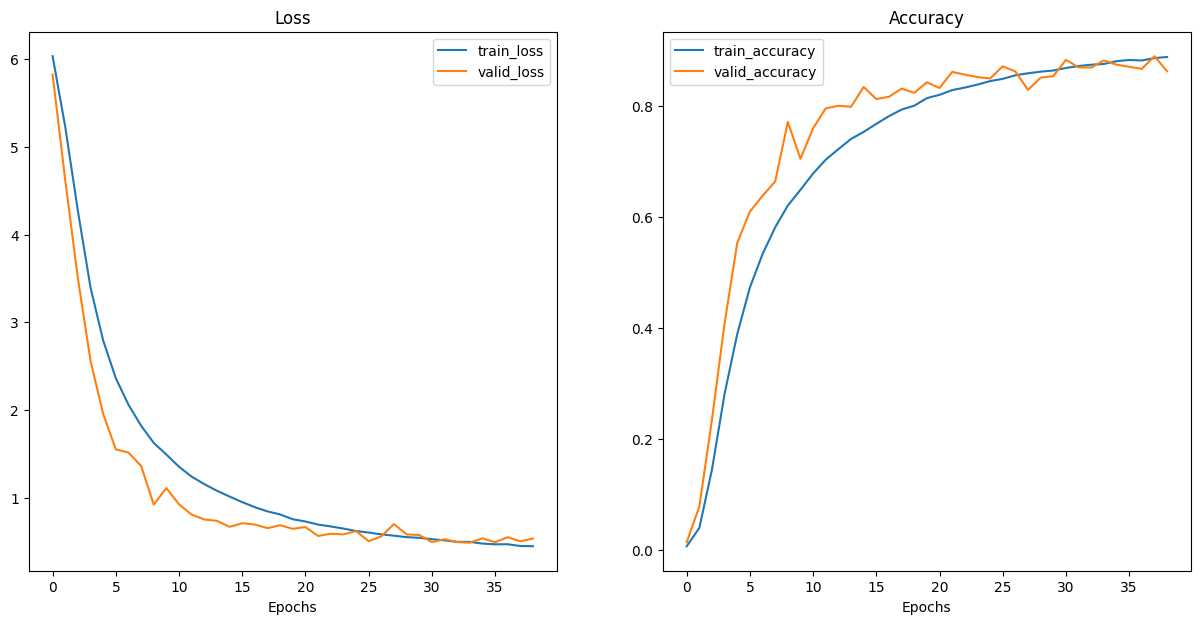

In [22]:
plot_loss_curves(model_1_results)

## 7: Test the model (test set)


In [23]:
loaded_best_birds = SurfinBird(input_shape=3,
                     hidden_units=256,
                     output_shape=len(train_data.classes))
loaded_best_birds.load_state_dict(torch.load(f="best_model_birds.pth"))
loaded_best_birds = loaded_best_birds.to(device)

In [24]:
correct_count, wrong_count, logits, predicted_labels, true_labels, test_loss, test_acc = test_step(
    model=loaded_best_birds,
    dataloader=test_dataloader,
    loss_fn=loss_fn)

report = classification_report(true_labels, predicted_labels, output_dict=True)

print(f"Etiqueta predicha:\n{test_data.classes[predicted_labels[7]]}\n")
print(f"Etiqueta actual:\n{test_data.classes[true_labels[7]]}\n")
print(f"Loss: {test_loss}")
print(f"AVG Accuracy: {report['accuracy']:.4f}\n")

print(f"Macro AVG Precision: {report['macro avg']['precision']:.4f}")
print(f"Macro AVG Recall: {report['macro avg']['recall']:.4f}")
print(f"Macro AVG F1: {report['macro avg']['f1-score']:.4f}")

print(f"weighted AVG Precision: {report['weighted avg']['precision']:.4f}")
print(f"weighted AVG Recall: {report['weighted avg']['recall']:.4f}")
print(f"weighted AVG F1: {report['weighted avg']['f1-score']:.4f}")

print(f"Predicciones total:{len(predicted_labels)}")
print(f"Etiquetas total:{len(true_labels)}")
print(f"Predicciones 0 - 10:\n{predicted_labels[:20]}")
print(f"Etiquetas 0 - 10:\n{true_labels[:20]}")
print(f"Correctas:{correct_count}")
print(f"Erroneas:{wrong_count}")

Etiqueta predicha:
KNOB BILLED DUCK

Etiqueta actual:
ABBOTTS BOOBY

Loss: 0.303244985640049
AVG Accuracy: 0.9162

Macro AVG Precision: 0.9310
Macro AVG Recall: 0.9162
Macro AVG F1: 0.9157
weighted AVG Precision: 0.9310
weighted AVG Recall: 0.9162
weighted AVG F1: 0.9157
Predicciones total:2625
Etiquetas total:2625
Predicciones 0 - 10:
[0, 0, 0, 0, 0, 1, 102, 321, 324, 1, 2, 2, 2, 2, 2, 3, 135, 3, 3, 3]
Etiquetas 0 - 10:
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
Correctas:2405
Erroneas:220
